In [1]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["image.cmap"] = 'magma'

from sklearn.metrics.pairwise import cosine_similarity

from damo.config.base import parse_config
from tools.demo import Infer

from my_help_functions.hooks import register_hooks
from my_help_functions.cosine_matrix import get_positions_of_classes_on_flattened_image, get_positions_of_classes_on_flattened_image_for_collage

In [2]:
config = parse_config('./configs/damoyolo_tinynasL20_T.py')
infer_engine = Infer(config, device='cuda',
    ckpt='./weights/damoyolo_tiny.pth')
model = infer_engine.model.eval()

Inference with torch engine!


In [3]:
# for name, layer in list(model.named_modules())[:1]:
#     print(name, layer)

In [4]:
layers_to_add = ['backbone.block_list.3.block_list.0.conv1.conv1',
                 'backbone.block_list.3.block_list.0.conv1.bn1'  
                ]
bn = model.backbone.block_list[3].block_list[0].conv1.bn1

# path = './assets/couches.jpg'
path = './collage_1.jpg'

In [5]:
layer_outputs_fwd = register_hooks(model, layers_to_add, False)

add backbone.block_list.3.block_list.0.conv1.conv1
add backbone.block_list.3.block_list.0.conv1.bn1


In [6]:
origin_image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
image, origin_shape = infer_engine.preprocess(origin_image)
output = model(image)

# bboxes, scores, cls_inds = infer_engine.postprocess(output, image, origin_shape=origin_shape)
# bboxes[0][0].backward()

forward hook used
forward hook used


In [7]:
from tabulate import tabulate

data = [(layer, str(embeddings[0].shape), str(embeddings[1].shape)) for layer, embeddings in layer_outputs_fwd.items()]
print(tabulate(data, headers=["Слой", "Размер входа", "Размер выхода"], tablefmt="grid"))

+----------------------------------------------------------------------------------+--------------------------+--------------------------+
| Слой                                                                             | Размер входа             | Размер выхода            |
+==================================================================================+==========================+==========================+
| Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)                    | torch.Size([96, 80, 80]) | torch.Size([96, 80, 80]) |
+----------------------------------------------------------------------------------+--------------------------+--------------------------+
| BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True) | torch.Size([96, 80, 80]) | torch.Size([96, 80, 80]) |
+----------------------------------------------------------------------------------+--------------------------+--------------------------+


In [8]:
conv = {}
conv['before conv'] = list(layer_outputs_fwd.values())[0][0]
conv['after conv']  = list(layer_outputs_fwd.values())[0][1]

# НЕ БУДЕТ РАБОТАТЬ НА ТРЕЙНЕ И С ВЫКЛЮЧЕННЫМИ РАННИНГ, МОЖНО VAR И MEAN В КЛАССЕ БН СДЕЛАТЬ ПОЛЯМИ
conv['after center'] = list(layer_outputs_fwd.values())[1][1] *\
                        torch.sqrt(bn.running_var.view(-1, 1, 1) + bn.eps)

In [9]:
for i, j in conv.items():
    print(i, j.shape)

before conv torch.Size([96, 80, 80])
after conv torch.Size([96, 80, 80])
after center torch.Size([96, 80, 80])


# Матрицы взаимных углов

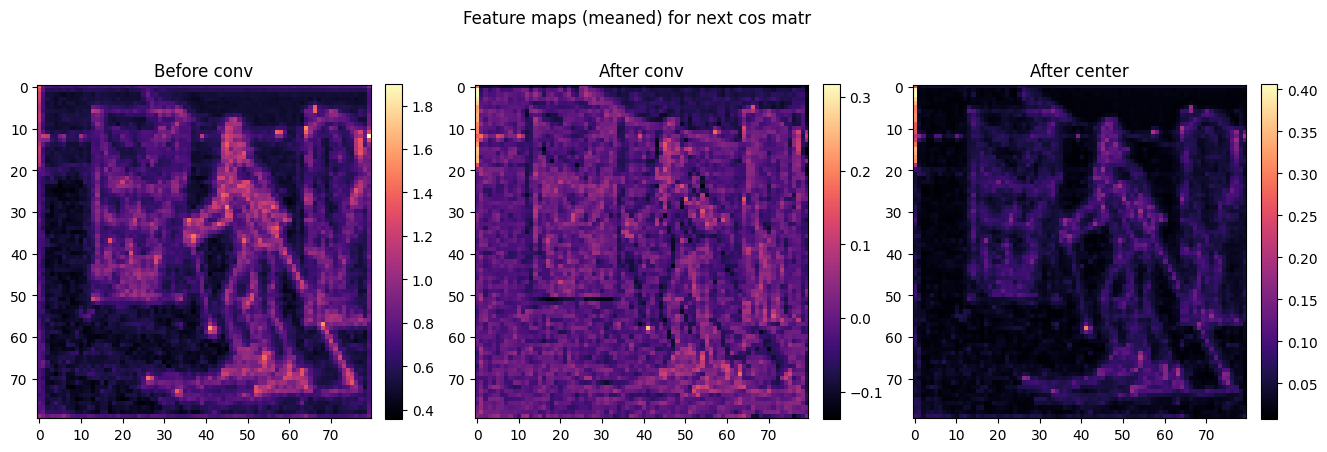

In [10]:
center = bn.running_mean.view(-1, 1, 1)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

img0 = axes[0].imshow(torch.mean(conv['before conv'], dim=0).detach().cpu())
img1 = axes[1].imshow(torch.mean(conv['after conv'], dim=0).detach().cpu())
img2 = axes[2].imshow(torch.mean(conv['after center'], dim=0).detach().cpu())
axes[0].set_title("Before conv")
axes[1].set_title("After conv")
axes[2].set_title("After center")

fig.colorbar(img0, ax=axes[0], fraction=0.046, pad=0.04)
fig.colorbar(img1, ax=axes[1], fraction=0.046, pad=0.04)
fig.colorbar(img2, ax=axes[2], fraction=0.046, pad=0.04)

plt.suptitle("Feature maps (meaned) for next cos matr")
plt.show();
# plt.savefig("Feature maps (meaned) for next cos matr.png")

In [11]:
to_create = ['before conv', 'after conv', 'after center']
matrices = {}
for name in to_create:
    vec = conv[name]
    reshaped = vec.reshape(vec.shape[1] * vec.shape[2], vec.shape[0]).detach().cpu().numpy()
    print(reshaped.shape)
    matrices[name] = reshaped
# matrices

(6400, 96)
(6400, 96)
(6400, 96)


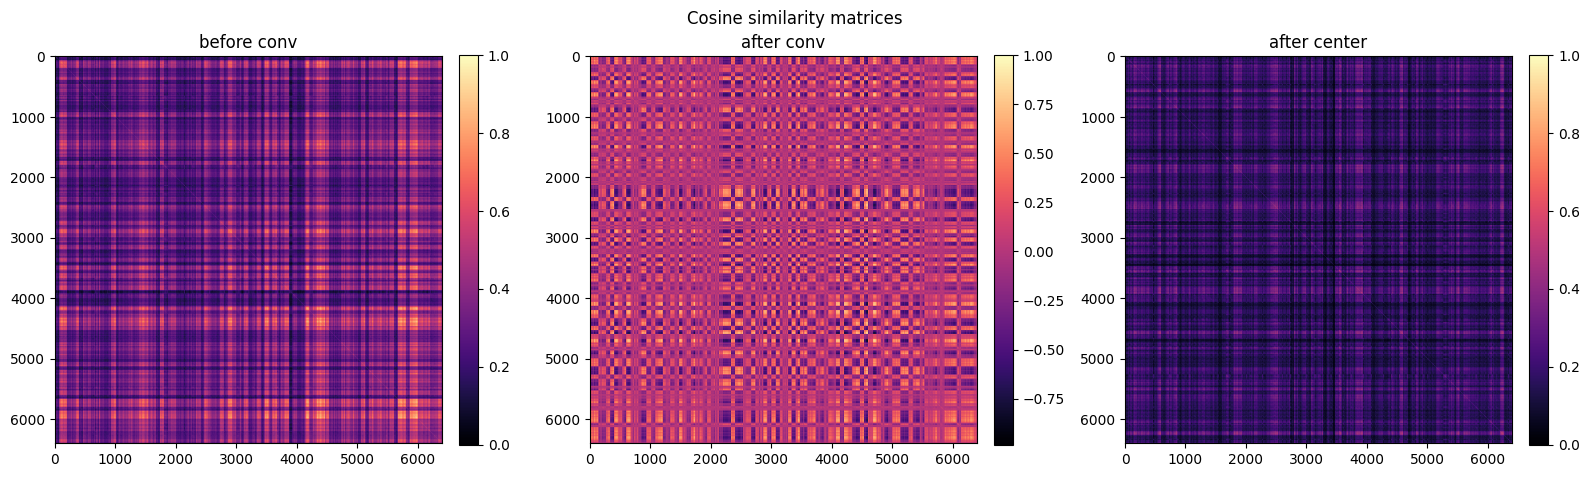

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
 
for name, ax in zip(matrices.keys(), axes.flat):
    img = ax.imshow(cosine_similarity(matrices[name], matrices[name]))
    ax.set_title(name)
    fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle("Cosine similarity matrices")
plt.show();
# plt.savefig("Cosine similarity matrices.png")

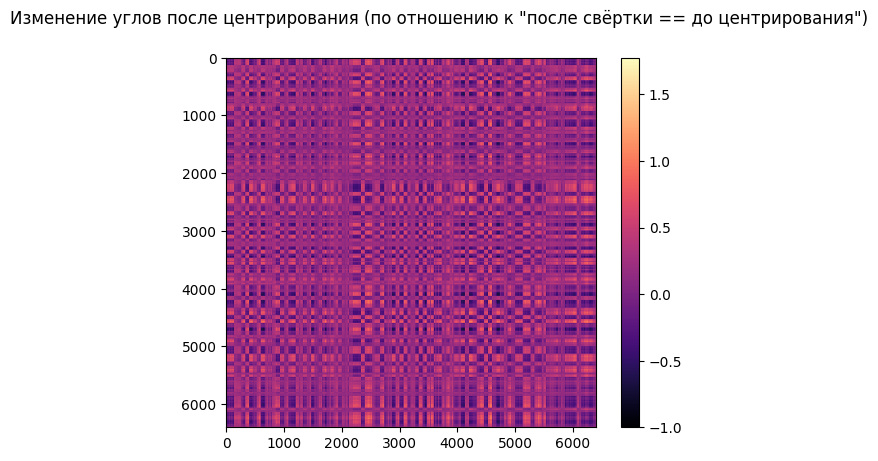

In [13]:
# МАТРИЦА ИЗМЕНЕНИЯ УГЛОВ до и после центрирования

plt.figure()
plt.imshow(cosine_similarity(matrices['after center'], matrices['after center']) - cosine_similarity(matrices['after conv'], matrices['after conv']))
plt.suptitle('Изменение углов после центрирования (по отношению к "после свёртки == до центрирования")')
plt.colorbar()
plt.show();
# plt.savefig("Angles change after center.png")

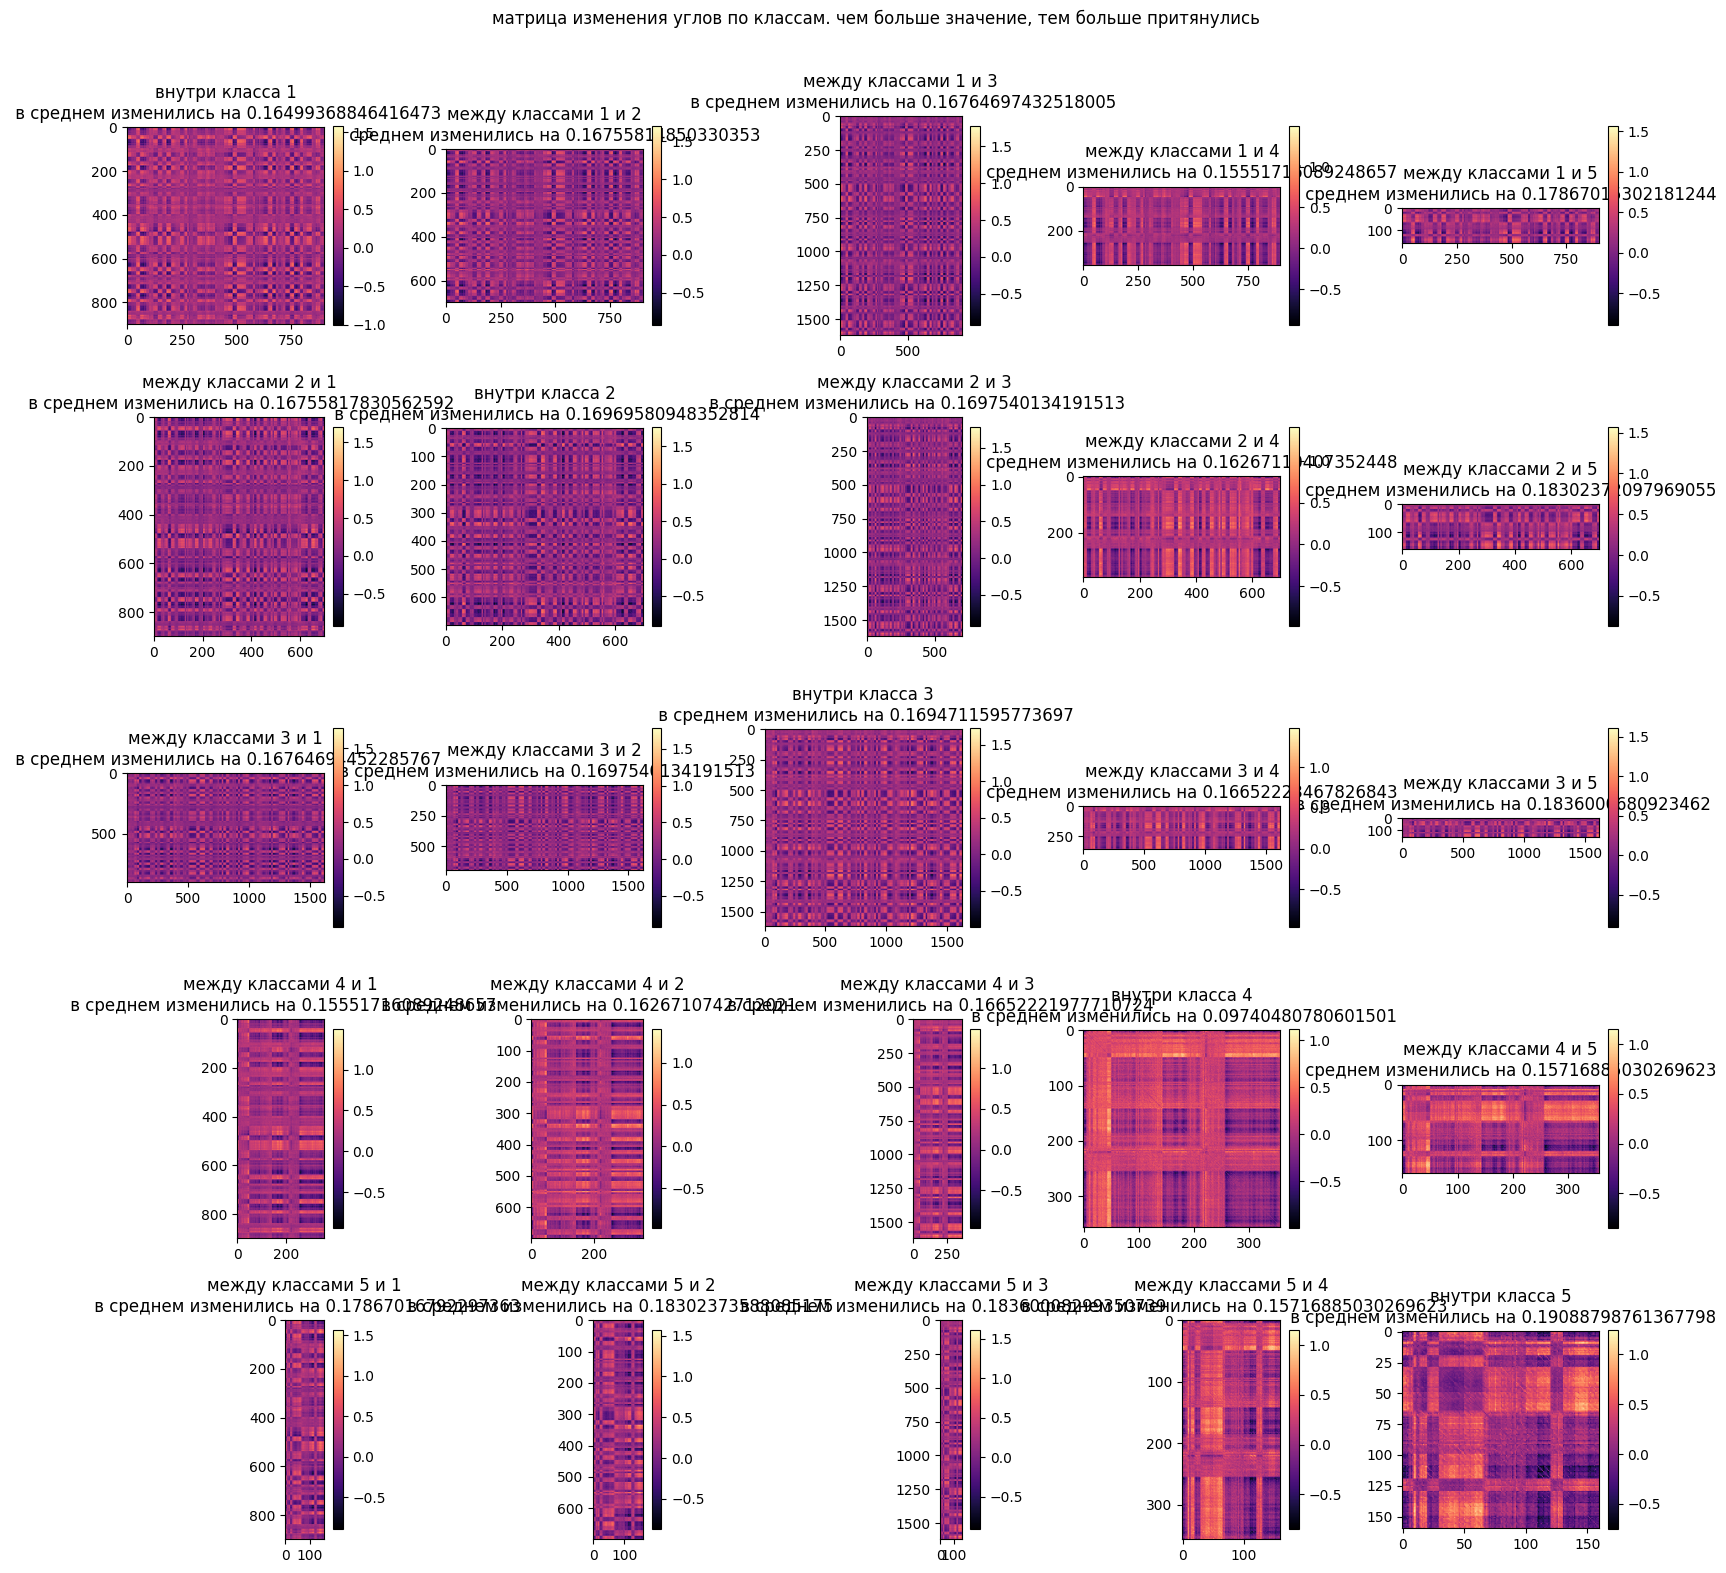

+---------+-------------------------+---------------------------------------+-------------+
|   Класс |   Изменение угла внутри |   Среднее изменение угла с остальными |     Разница |
+=========+=========================+=======================================+=============+
|       1 |               0.164994  |                              0.167348 | -0.00235442 |
+---------+-------------------------+---------------------------------------+-------------+
|       2 |               0.169696  |                              0.170752 | -0.00105594 |
+---------+-------------------------+---------------------------------------+-------------+
|       3 |               0.169471  |                              0.171881 | -0.00240966 |
+---------+-------------------------+---------------------------------------+-------------+
|       4 |               0.0974048 |                              0.16047  | -0.063065   |
+---------+-------------------------+---------------------------------------+---

In [14]:
# ПРО КЛАССЫ

# positions = get_positions_of_classes_on_flattened_image('000000004495.jpg', 80)
positions = get_positions_of_classes_on_flattened_image_for_collage(1, 80)


cos_sim_matr = cosine_similarity(matrices['after center'], matrices['after center']) - cosine_similarity(matrices['after conv'], matrices['after conv'])

rows = cols = len(positions)
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

diff = []

for i in range(rows):
    mean_angle_change_w_others = 0
    angle_change_w_self = 0
    for j in range(cols):
        pair_matrix = np.array(np.meshgrid(positions[i + 1], positions[j + 1]))
        submatrix = cos_sim_matr[pair_matrix[0], pair_matrix[1]]
        img = axes[i][j].imshow(submatrix)

        if i != j:
            mean_angle_change_w_others += np.mean(submatrix)
        else:
            angle_change_w_self = np.mean(submatrix)
        axes[i][j].set_title((f'между классами {i + 1} и {j + 1}' if i != j else f'внутри класса {i + 1}') + f'\n в среднем изменились на {np.mean(submatrix)}')

        fig.tight_layout()
        fig.colorbar(img, ax=axes[i][j], fraction=0.046, pad=0.04)
    mean_angle_change_w_others /= (cols - 1)
    diff += [[i + 1, angle_change_w_self, mean_angle_change_w_others, angle_change_w_self - mean_angle_change_w_others]]


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('матрица изменения углов по классам. чем больше значение, тем больше притянулись')
plt.show()
# plt.savefig("Submatrices.png")

for i in range(len(diff)):
    for j in range(4):
        diff[i][j] = str(diff[i][j])
    diff[i] = tuple(diff[i])
print(tabulate(diff, headers=["Класс", "Изменение угла внутри", "Среднее изменение угла с остальными", "Разница"], tablefmt="grid"))

# Что-то про БН и фон

In [15]:
# Считаем нормы до-после центрирования и прочее

# норма центра
print(torch.linalg.norm(bn.running_mean))

# средняя норма "до"
print(torch.mean(torch.norm(conv['after conv'], dim=(1, 2))))

# средняя норма "после"
print(torch.mean(torch.norm(conv['after center'], dim=(1, 2))))

tensor(1.3717, device='cuda:0')
tensor(19.9486, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.4052, device='cuda:0', grad_fn=<MeanBackward0>)


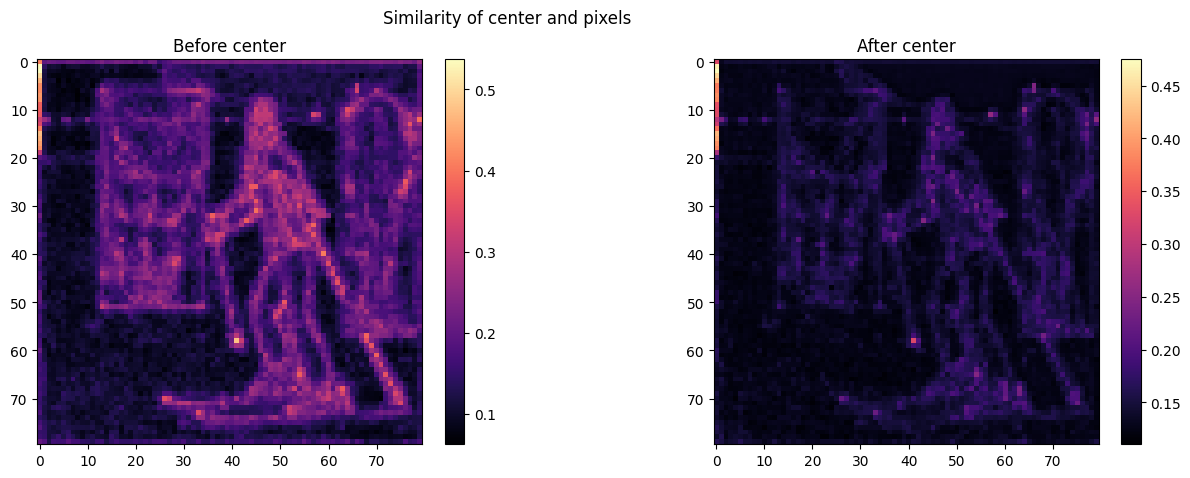

In [16]:
# МАТРИЦА ПОХОЖЕСТИ ЦЕНТРА НА ПИКСЕЛИ ИЗОБРАЖЕНИЯ

# after, after center ? - то есть до и после центрирования

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

img0 = axes[0].imshow(torch.mean(abs(center - conv['after conv']), dim=0).detach().cpu())
img1 = axes[1].imshow(torch.mean(abs(center - conv['after center']), dim=0).detach().cpu())
axes[0].set_title("Before center")
axes[1].set_title("After center")

fig.colorbar(img0, ax=axes[0], fraction=0.046, pad=0.04)
fig.colorbar(img1, ax=axes[1], fraction=0.046, pad=0.04)

plt.suptitle("Similarity of center and pixels")
plt.show();
# plt.savefig("Similarity of center and pixels.png")

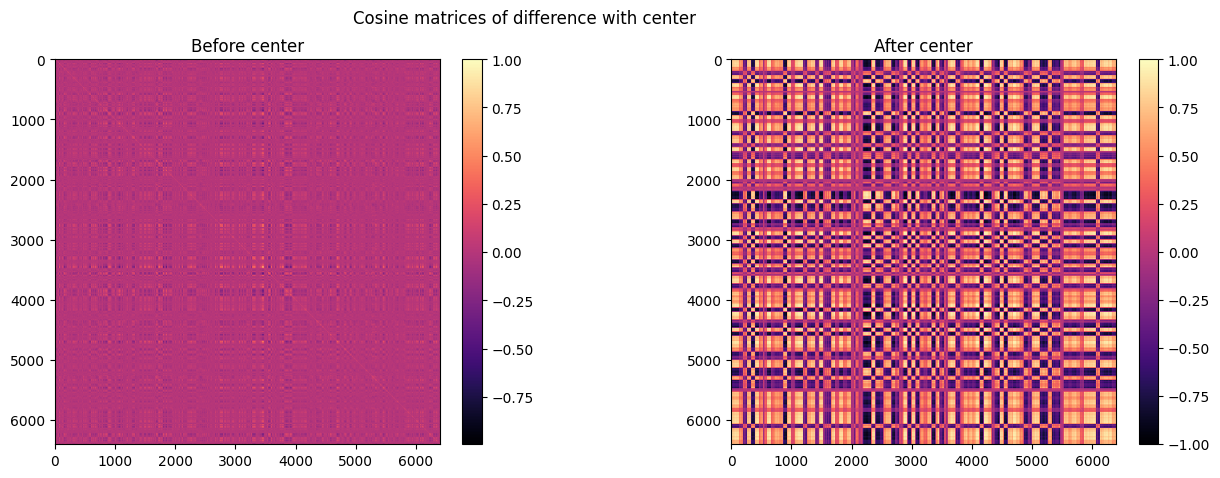

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

def cossim(vec):
    reshaped = vec.reshape(vec.shape[1] * vec.shape[2], vec.shape[0]).detach().cpu().numpy()
    return cosine_similarity(reshaped, reshaped)

img0 = axes[0].imshow(cossim(center - conv['after conv']))
img1 = axes[1].imshow(cossim(center - conv['after center']))
axes[0].set_title("Before center")
axes[1].set_title("After center")

fig.colorbar(img0, ax=axes[0], fraction=0.046, pad=0.04)
fig.colorbar(img1, ax=axes[1], fraction=0.046, pad=0.04)

plt.suptitle("Cosine matrices of difference with center")
plt.show();
# plt.savefig("Cos matr of simmilarity.png")

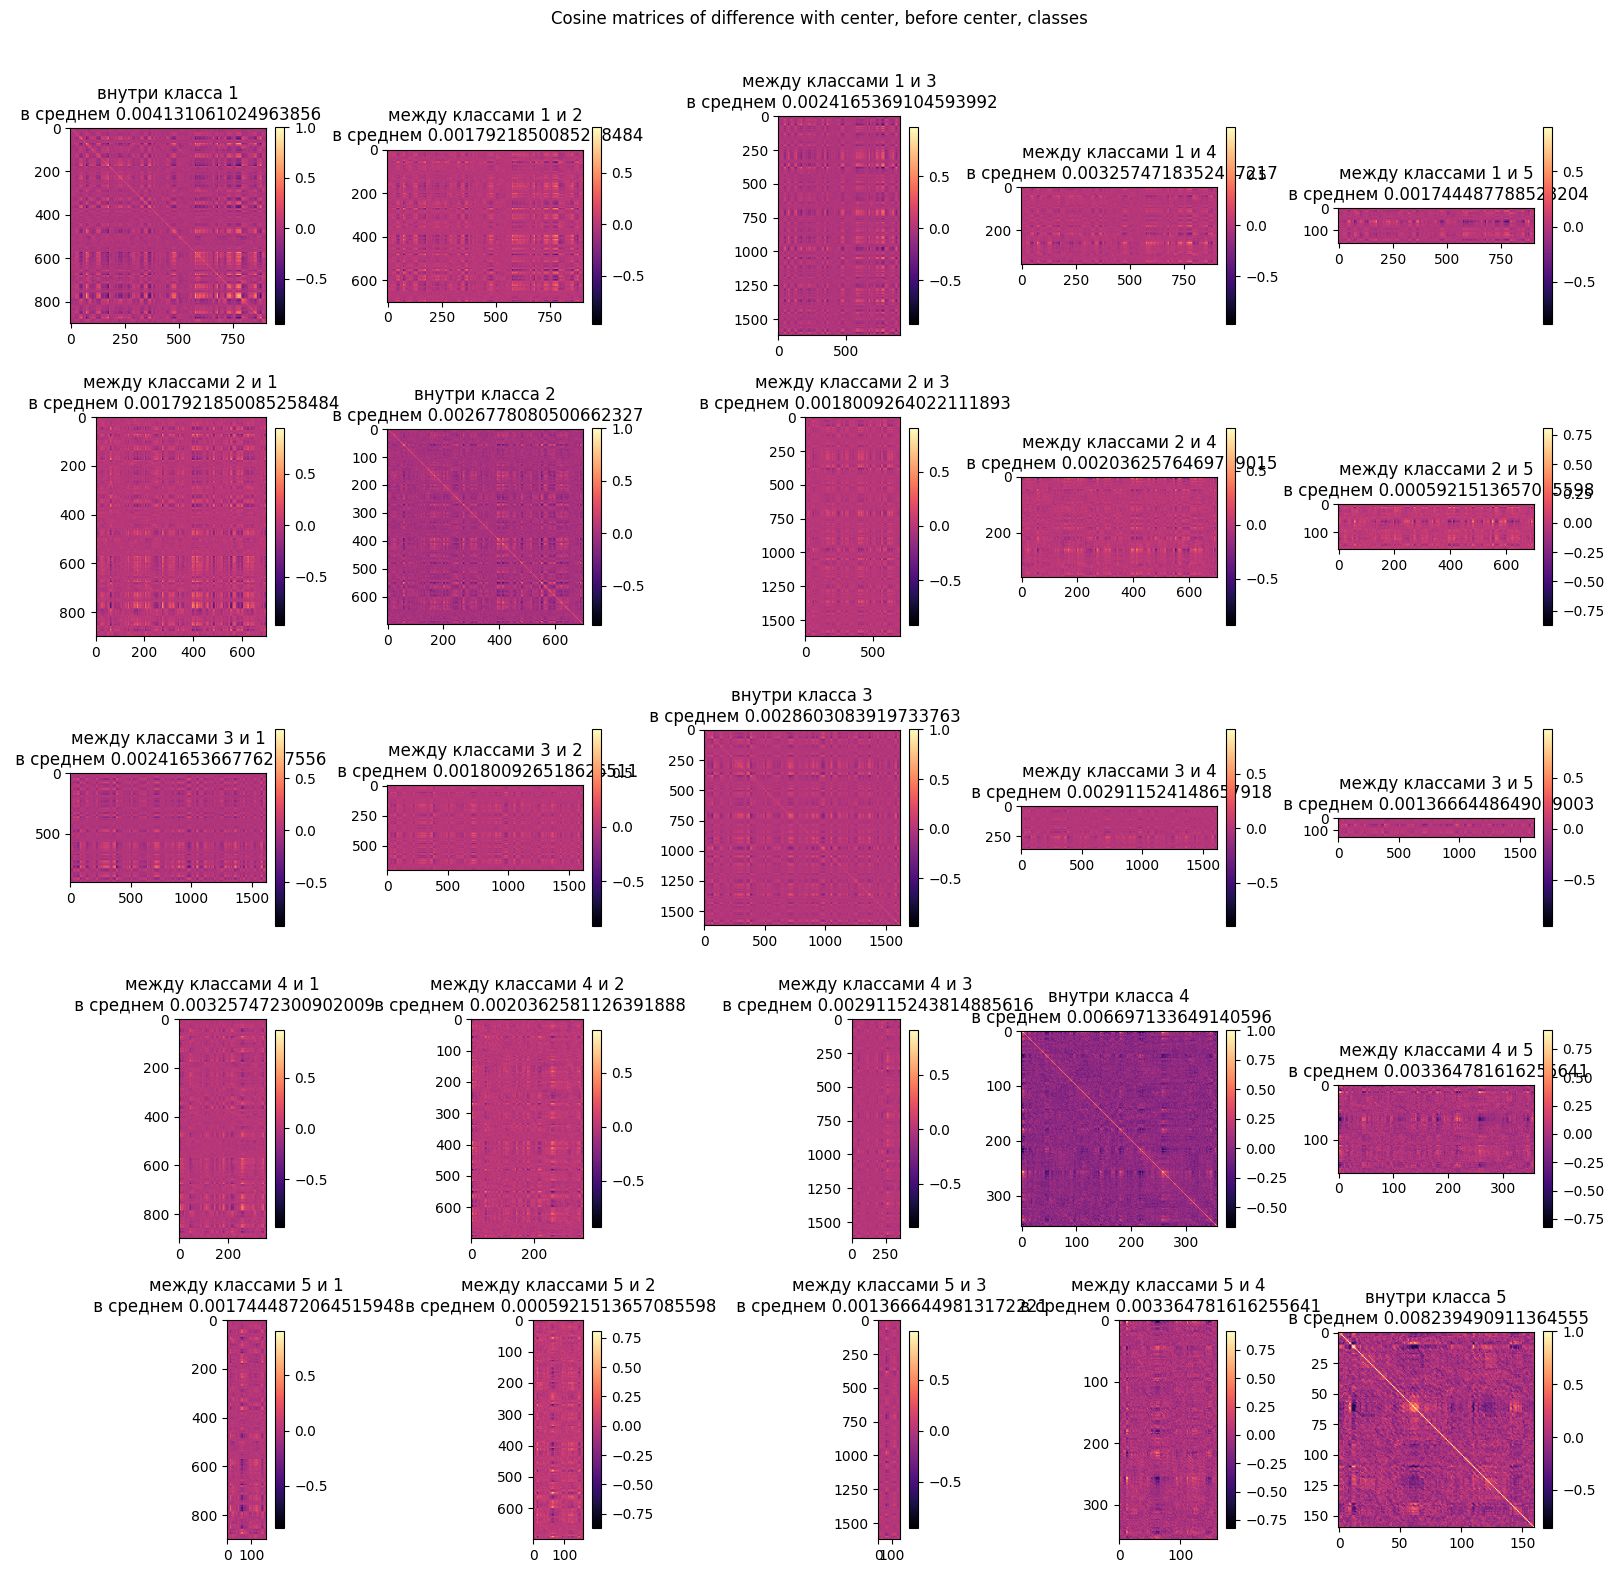

In [18]:
cos_sim_matr = cossim(center - conv['after conv'])

rows = cols = len(positions)
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

diff = []

for i in range(rows):
    mean_angle_change_w_others = 0
    angle_change_w_self = 0
    for j in range(cols):
        pair_matrix = np.array(np.meshgrid(positions[i + 1], positions[j + 1]))
        submatrix = cos_sim_matr[pair_matrix[0], pair_matrix[1]]
        img = axes[i][j].imshow(submatrix)

        if i != j:
            mean_angle_change_w_others += np.mean(submatrix)
        else:
            angle_change_w_self = np.mean(submatrix)
        axes[i][j].set_title((f'между классами {i + 1} и {j + 1}' if i != j else f'внутри класса {i + 1}') + f'\n в среднем {np.mean(submatrix)}')

        fig.tight_layout()
        fig.colorbar(img, ax=axes[i][j], fraction=0.046, pad=0.04)
    mean_angle_change_w_others /= (cols - 1)
    diff += [[i + 1, angle_change_w_self, mean_angle_change_w_others, angle_change_w_self - mean_angle_change_w_others]]


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Cosine matrices of difference with center, before center, classes')
plt.show();
# plt.savefig("Submatrices_for_center-pixel.png")

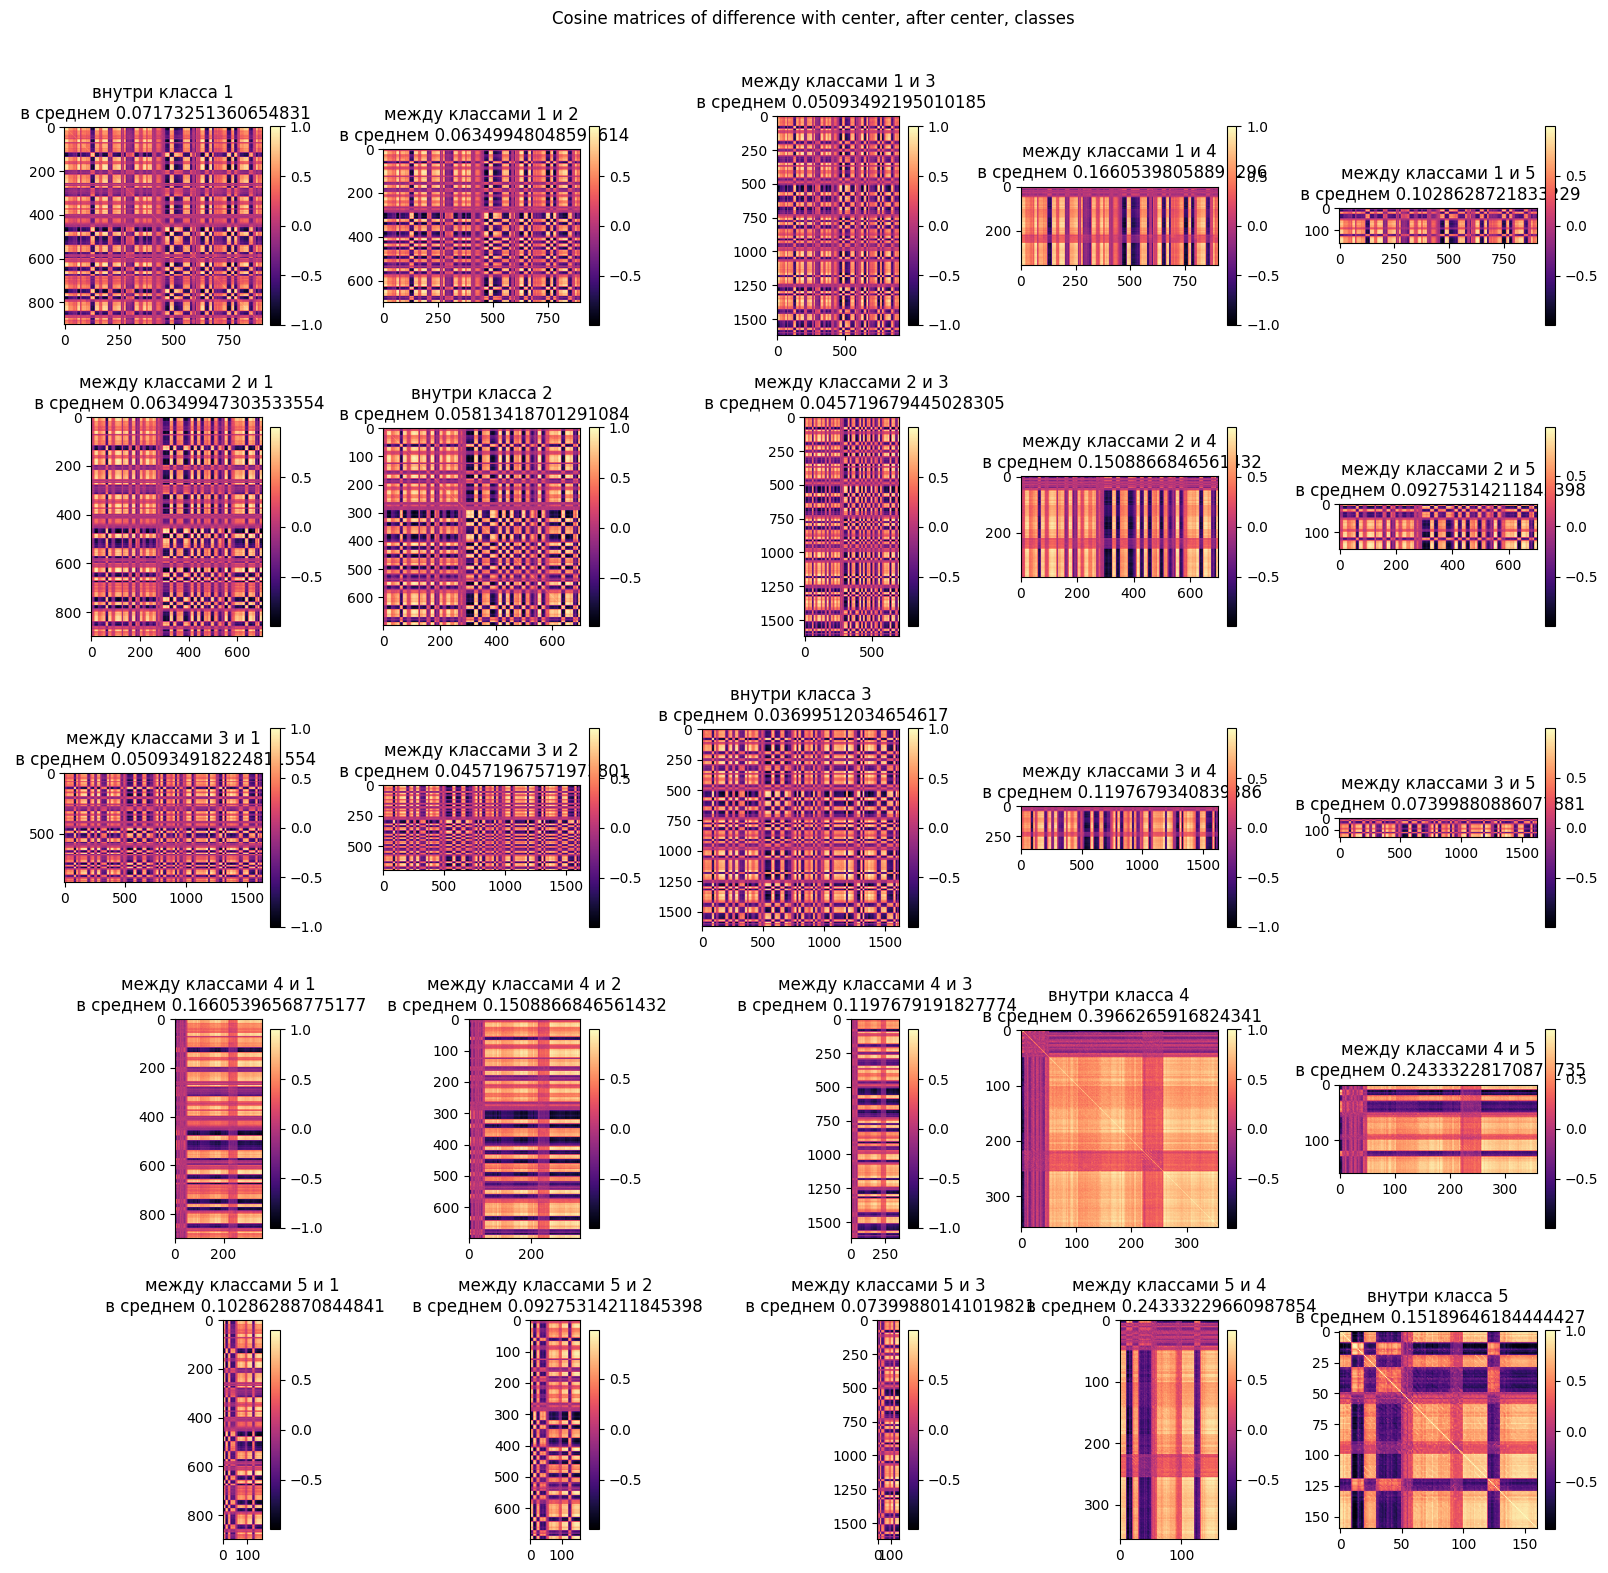

In [19]:
cos_sim_matr = cossim(center - conv['after center'])

rows = cols = len(positions)
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

diff = []

for i in range(rows):
    mean_angle_change_w_others = 0
    angle_change_w_self = 0
    for j in range(cols):
        pair_matrix = np.array(np.meshgrid(positions[i + 1], positions[j + 1]))
        submatrix = cos_sim_matr[pair_matrix[0], pair_matrix[1]]
        img = axes[i][j].imshow(submatrix)

        if i != j:
            mean_angle_change_w_others += np.mean(submatrix)
        else:
            angle_change_w_self = np.mean(submatrix)
        axes[i][j].set_title((f'между классами {i + 1} и {j + 1}' if i != j else f'внутри класса {i + 1}') + f'\n в среднем {np.mean(submatrix)}')

        fig.tight_layout()
        fig.colorbar(img, ax=axes[i][j], fraction=0.046, pad=0.04)
    mean_angle_change_w_others /= (cols - 1)
    diff += [[i + 1, angle_change_w_self, mean_angle_change_w_others, angle_change_w_self - mean_angle_change_w_others]]


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Cosine matrices of difference with center, after center, classes')
plt.show();
# plt.savefig("Submatrices_for_center-pixel.png")